* Froude number plots at peak ebbs and floods.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools)
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import R_mixStuff as RS
import FroudeNumber as FN
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.6, rc={"lines.linewidth": 2.5})
%matplotlib inline


In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 
e3t = mesh.variables['e3t'][0,:,380:510,240:397]


In [3]:
## Jan results
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc','r')
janall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_U.nc','r')
janall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_V.nc','r')

## Oct results
octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc','r')
octall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc','r')
octall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc','r')

## May results
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc','r')
mayall_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_U.nc','r')
mayall_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_V.nc','r')


In [4]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    if ave_flag == False:
        S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
        S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    elif ave_flag == True:
        S_ref = np.nanmean(S_aveN[0:dep_ind+1]) ## then spatial average, including depth
        S_aveW = np.nanmean(np.nanmean(S[tst:ted],axis = 0),axis = 0)
    S_thre = 1.14*S_ref-4.8
    #S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0) ## temporal averaged of the whole domain
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW


In [5]:
def calculate_density(t, s):
    """Caluclates the density given temperature in deg C (t)
    and salinity in psu (s).

    returns the density as an array (rho)
    """
    rho = (
        999.842594 + 6.793952e-2 * t
        - 9.095290e-3 * t*t + 1.001685e-4 * t*t*t
        - 1.120083e-6 * t*t*t*t + 6.536332e-9 * t*t*t*t*t
        + 8.24493e-1 * s - 4.0899e-3 * t*s
        + 7.6438e-5 * t*t*s - 8.2467e-7 * t*t*t*s
        + 5.3875e-9 * t*t*t*t*s - 5.72466e-3 * s**1.5
        + 1.0227e-4 * t*s**1.5 - 1.6546e-6 * t*t*s**1.5
        + 4.8314e-4 * s*s)
    return rho


* Calculation
* Fr = $\frac{\Delta U}{\sqrt{g^{'}h}}$, where

$\Delta U = \sqrt{(u_{s}-u_{b})^2 + (v_{s}-v_{b})^2}$

$g^{'} = g  \frac{\rho_{b} - \rho_{s}}{\rho_{0}}$

h will be found by looking at where $\frac{\partial \rho}{\partial z}$ reaches maximum

$u_{s} = \frac{\int_{0}^{h} u dz}{\int_{0}^{h} dz}$,  $v_{s} = \frac{\int_{0}^{h} v dz}{\int_{0}^{h} dz}$

$u_{b} = \frac{\int_{h}^{H-h} u dz}{\int_{h}^{H-h} dz}$,  $v_{b} = \frac{\int_{h}^{H-h} v dz}{\int_{h}^{H-h} dz}$

$\rho_{s} = \frac{\int_{0}^{h} \rho dz}{\int_{0}^{h} dz}$

$\rho_{b} = \frac{\int_{h}^{H-h} \rho dz}{\int_{h}^{H-h} dz}$

g = 9.8 m $^{2}s^{-1}$,

$\rho_{0}$ = 1023.8 kg m$^{-3}$

In [56]:
ti = 'all'
ssh = {};T={};S={};u = {};v = {};
t = 196
grid_T = octall_T
grid_U = octall_U
grid_V = octall_V
ssh[ti] = grid_T.variables['sossheig']
T[ti] = grid_T.variables['votemper'][t] ## to calculate rho
T[ti] = np.ma.masked_array(T[ti],mask = np_mask) ## mask 0 values, very important!!! Or density integral is negative sometimes
S[ti] = grid_T.variables['vosaline'][t]
S[ti] = np.ma.masked_array(S[ti],mask= np_mask)
dep = grid_T.variables['deptht']
rho = calculate_density(T[ti],S[ti])

u[ti] = grid_U.variables['vozocrtx']
v[ti] = grid_V.variables['vomecrty']
u[ti],v[ti] = viz_tools.unstagger(u[ti][t],v[ti][t])


In [66]:
U_upper = np.zeros([40,129,156])
V_upper = np.zeros([40,129,156])
U_bottom = np.zeros([40,129,156])
V_bottom = np.zeros([40,129,156])
Rho_upper = np.zeros([40,130,157])
Rho_bottom = np.zeros([40,130,157])
Upper_depthsRho = np.zeros([40,130,157])
Bottom_depthsRho = np.zeros([40,130,157])
Upper_depthsUV = np.zeros([40,129,156])
Bottom_depthsUV = np.zeros([40,129,156])
H = np.zeros([130,157])
for j in range(130):
    for i in range(157):
        z_ind = np.nanargmax(np.diff(rho[:,j,i])/np.diff(dep)) ## find max depth index of partial rho/partial z
        H[j,i] = dep[z_ind +1]
        for z in range(40):
            if z <= z_ind +1: ## for upper layer rho
                adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                Rho_upper[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                Upper_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                if (j< 129) and (i<156): ## for upper layer velocity, note already unstaggered
                    adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                    U_upper[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    V_upper[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    Upper_depthsUV[z,j,i] = e3t[z,j+1,i+1]*adj_sshUV*tmask[z,j+1,i+1]
                    
            if z > z_ind +1: ## bottom layer rho
                adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                Rho_bottom[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                Bottom_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                if (j< 129) and (i<156): ## for bottom layer velocity, note already unstaggered
                    adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                    U_bottom[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    V_bottom[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                    Bottom_depthsUV[z,j,i] = e3t[z,j+1,i+1] * adj_sshUV * tmask[z,j+1,i+1]      
                    

In [195]:
g= 9.8
rho_0 = 1023.8
## Integral for velocity
U_upperTotal = np.nansum(U_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
V_upperTotal = np.nansum(V_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
U_bottomTotal = np.nansum(U_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)
V_bottomTotal = np.nansum(V_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)

Delta_Velocity = np.sqrt((U_upperTotal-U_bottomTotal)**2+(V_upperTotal- V_bottomTotal)**2)
## Integral of rho
Rho_upperTotal = np.nansum(Rho_upper,axis = 0)/np.nansum(Upper_depthsRho,axis = 0)
Rho_bottomTotal = np.nansum(Rho_bottom,axis = 0)/np.nansum(Bottom_depthsRho,axis = 0)
## Reduced gravity
g_prime = g* (Rho_bottomTotal-Rho_upperTotal)/rho_0
g_prime[g_prime<=0]=np.nan ## some unstable numbers in the rivers and boundaries

## Froude number 
Fr = Delta_Velocity/np.sqrt(g_prime[1:,1:] * H[1:,1:])

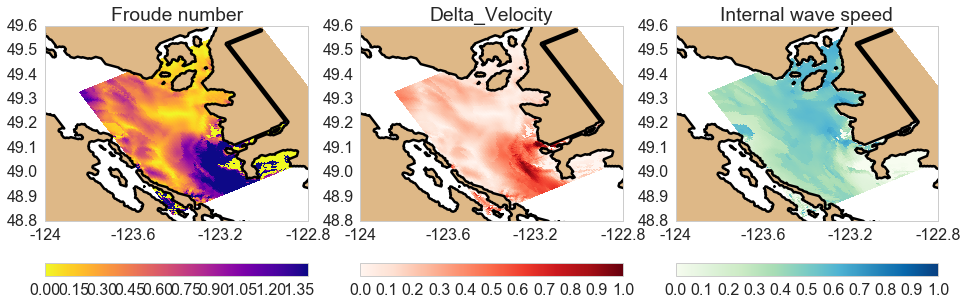

In [198]:
fig,axs =plt.subplots(1,3,figsize = (16,5))
ax= axs[0]
mesh=ax.pcolormesh(lon[1:,1:],lat[1:,1:],Fr,cmap = 'plasma_r',vmin=0, vmax=1.4)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Froude number')

ax = axs[1]
mesh=ax.pcolormesh(lon[1:,1:],lat[1:,1:],Delta_Velocity,cmap = 'Reds',vmin=0, vmax=1)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Delta_Velocity')

ax = axs[2]
mesh=ax.pcolormesh(lon[:],lat[:],np.sqrt(g_prime[1:,1:] * H[1:,1:]),cmap = 'GnBu',vmin=0, vmax=1)
cbar = fig.colorbar(mesh,ax = ax,orientation = 'horizontal')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_title('Internal wave speed')
for ax in axs:
    ax.set_xlim([-124.,-122.8])
    ax.set_xticks([-124,-123.6,-123.2,-122.8])
    ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
    ax.set_ylim([48.8,49.6])
    

(48.7, 49.7)

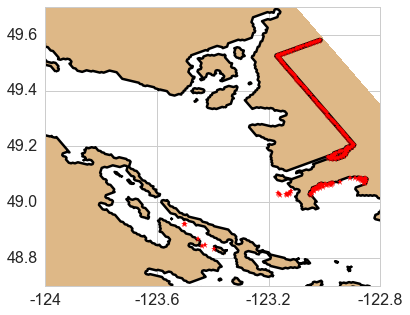

In [149]:
## some unstable grids where reduced gravity is negative
lon = grid_T.variables['nav_lon']
lat = grid_T.variables['nav_lat']
fig ,ax =plt.subplots(1,1,figsize = (6,5))
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
for j in range(130):
    for i in range(157):
        if np.nansum(Rho_bottom,axis = 0)[j,i]/np.nansum(Bottom_depthsRho,axis = 0)[j,i] - \
        np.nansum(Rho_upper,axis = 0)[j,i]/np.nansum(Upper_depthsRho,axis = 0)[j,i] <=0:
            ax.plot(lon[j,i],lat[j,i],'r*') ## cross -strait
ax.set_xlim([-124.,-122.8])
ax.set_xticks([-124,-123.6,-123.2,-122.8])
ax.set_xticklabels([-124,-123.6,-123.2,-122.8])
ax.set_ylim([48.7,49.7])


In [201]:
np.nanmax(Fr)

73.548177282710341

* Compile as a function

In [6]:
def Extract_UVRHO(grid_T,grid_U,grid_V,np_mask,t,ti):
    """
    """
    #ti = 'all'
    ssh = {};T={};S={};u = {};v = {};
    #t = 196
    #grid_T = octall_T
    #grid_U = octall_U
    #grid_V = octall_V
    ssh[ti] = grid_T.variables['sossheig']
    T[ti] = grid_T.variables['votemper'][t] ## to calculate rho
    T[ti] = np.ma.masked_array(T[ti],mask = np_mask) ## mask 0 values, very important!!! Or density integral is negative sometimes
    S[ti] = grid_T.variables['vosaline'][t]
    S[ti] = np.ma.masked_array(S[ti],mask= np_mask)
    dep = grid_T.variables['deptht']
    rho = calculate_density(T[ti],S[ti])

    u[ti] = grid_U.variables['vozocrtx']
    v[ti] = grid_V.variables['vomecrty']
    u[ti],v[ti] = viz_tools.unstagger(u[ti][t],v[ti][t])
    return rho, u, v,dep, ssh

In [14]:
def Calculate_Froude_Number(rho,u,v,dep,ssh,e3t,tmask, ti):
    """
    Calculate the discrete numerator and denominator of the Froude number
    
    """
    U_upper = np.zeros([40,129,156])
    V_upper = np.zeros([40,129,156])
    U_bottom = np.zeros([40,129,156])
    V_bottom = np.zeros([40,129,156])
    Rho_upper = np.zeros([40,130,157])
    Rho_bottom = np.zeros([40,130,157])
    Upper_depthsRho = np.zeros([40,130,157])
    Bottom_depthsRho = np.zeros([40,130,157])
    Upper_depthsUV = np.zeros([40,129,156])
    Bottom_depthsUV = np.zeros([40,129,156])
    H = np.zeros([130,157])
    for j in range(130):
        for i in range(157):
            z_ind = np.nanargmax(np.diff(rho[:,j,i])/np.diff(dep)) ## find max depth index of partial rho/partial z
            H[j,i] = dep[z_ind +1]
            for z in range(40):
                if z <= z_ind +1: ## for upper layer rho
                    adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                    Rho_upper[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                    Upper_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                    if (j< 129) and (i<156): ## for upper layer velocity, note already unstaggered
                        adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                        U_upper[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                        V_upper[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                        Upper_depthsUV[z,j,i] = e3t[z,j+1,i+1]*adj_sshUV*tmask[z,j+1,i+1]

                if z > z_ind +1: ## bottom layer rho
                    adj_sshRho = 1+ssh[ti][t,j,i]/np.sum(e3t[:,j,i]*tmask[:,j,i],axis = 0)
                    Rho_bottom[z,j,i] = rho[z,j,i]* e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                    Bottom_depthsRho[z,j,i] = e3t[z,j,i]*adj_sshRho*tmask[z,j,i]
                    if (j< 129) and (i<156): ## for bottom layer velocity, note already unstaggered
                        adj_sshUV = 1+ssh[ti][t,j+1,i+1]/np.sum(e3t[:,j+1,i+1]*tmask[:,j+1,i+1],axis = 0)
                        U_bottom[z,j,i] = u[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                        V_bottom[z,j,i] = v[ti][z,j,i]* e3t[z,j+1,i+1]*adj_sshUV * tmask[z,j+1,i+1]
                        Bottom_depthsUV[z,j,i] = e3t[z,j+1,i+1] * adj_sshUV * tmask[z,j+1,i+1]   
    return U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,Upper_depthsUV,Upper_depthsRho,\
           Bottom_depthsUV,Bottom_depthsRho, H

In [90]:
def Final_Froude_Number(U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,Upper_depthsUV,Upper_depthsRho,\
                       Bottom_depthsUV,Bottom_depthsRho,H):
    """
    Calculate the final Froude number as well as the integral of numerator and denominator
    """
    g= 9.8
    rho_0 = 1023
    U_bottomTotal = np.zeros([129,156])
    V_bottomTotal = np.zeros([129,156])
    Rho_bottomTotal = np.zeros([130,157])
    ## Integral for velocity
    U_upperTotal = np.nansum(U_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
    V_upperTotal = np.nansum(V_upper,axis = 0)/np.nansum(Upper_depthsUV,axis =0)
    
    
    for j in range(129):
        for i in range(156):
            if np.nansum(Bottom_depthsUV[:,j,i],axis =0) ==0:
                U_bottomTotal[j,i] = 0
                V_bottomTotal[j,i] = 0
            else:
                U_bottomTotal[j,i] = np.nansum(U_bottom[:,j,i],axis = 0)/np.nansum(Bottom_depthsUV[:,j,i],axis =0)
                V_bottomTotal[j,i] = np.nansum(V_bottom[:,j,i],axis = 0)/np.nansum(Bottom_depthsUV[:,j,i],axis =0)
                

    #U_bottomTotal = np.nansum(U_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)
    #V_bottomTotal = np.nansum(V_bottom,axis = 0)/np.nansum(Bottom_depthsUV,axis =0)

    Delta_Velocity = np.sqrt((U_upperTotal-U_bottomTotal)**2+(V_upperTotal- V_bottomTotal)**2)
    ## Integral of rho
    Rho_upperTotal = np.nansum(Rho_upper,axis = 0)/np.nansum(Upper_depthsRho,axis = 0)
    for j in range(130):
        for i in range(157):
            if np.nansum(Bottom_depthsRho[:,j,i],axis =0) ==0:
                Rho_bottomTotal[j,i] = rho_0 ## here I'm assuming if upper layer occuppies whole water column (at
                ## banks), then bottom rho is set to rho_0
            else:
                Rho_bottomTotal[j,i] = np.nansum(Rho_bottom[:,j,i],axis = 0)/np.nansum(Bottom_depthsRho[:,j,i],axis = 0)
                
    #Rho_bottomTotal = np.nansum(Rho_bottom,axis = 0)/np.nansum(Bottom_depthsRho,axis = 0)
    ## Reduced gravity
    g_prime = g* (Rho_bottomTotal-Rho_upperTotal)/rho_0
    g_prime[g_prime<=0]=np.nan ## some unstable numbers in the rivers and boundaries
    
    ## Internal wave speed
    IWS = np.sqrt(g_prime[1:,1:] * H[1:,1:])

    ## Froude number 
    Fr = Delta_Velocity/IWS
    return Delta_Velocity, IWS, Fr

* For three plots

In [75]:
## colormap levels
levels_Fr = [0,0.2,0.4,0.6,0.8,1]
levels_M = [0,0.2,0.4,0.6,0.8,1]
levels_B = [0,0.2,0.4,0.6,0.8,1]

lonmin = -124.
lonmax = -122.8
latmin = 48.9
latmax = 49.5 

ti = 'all'

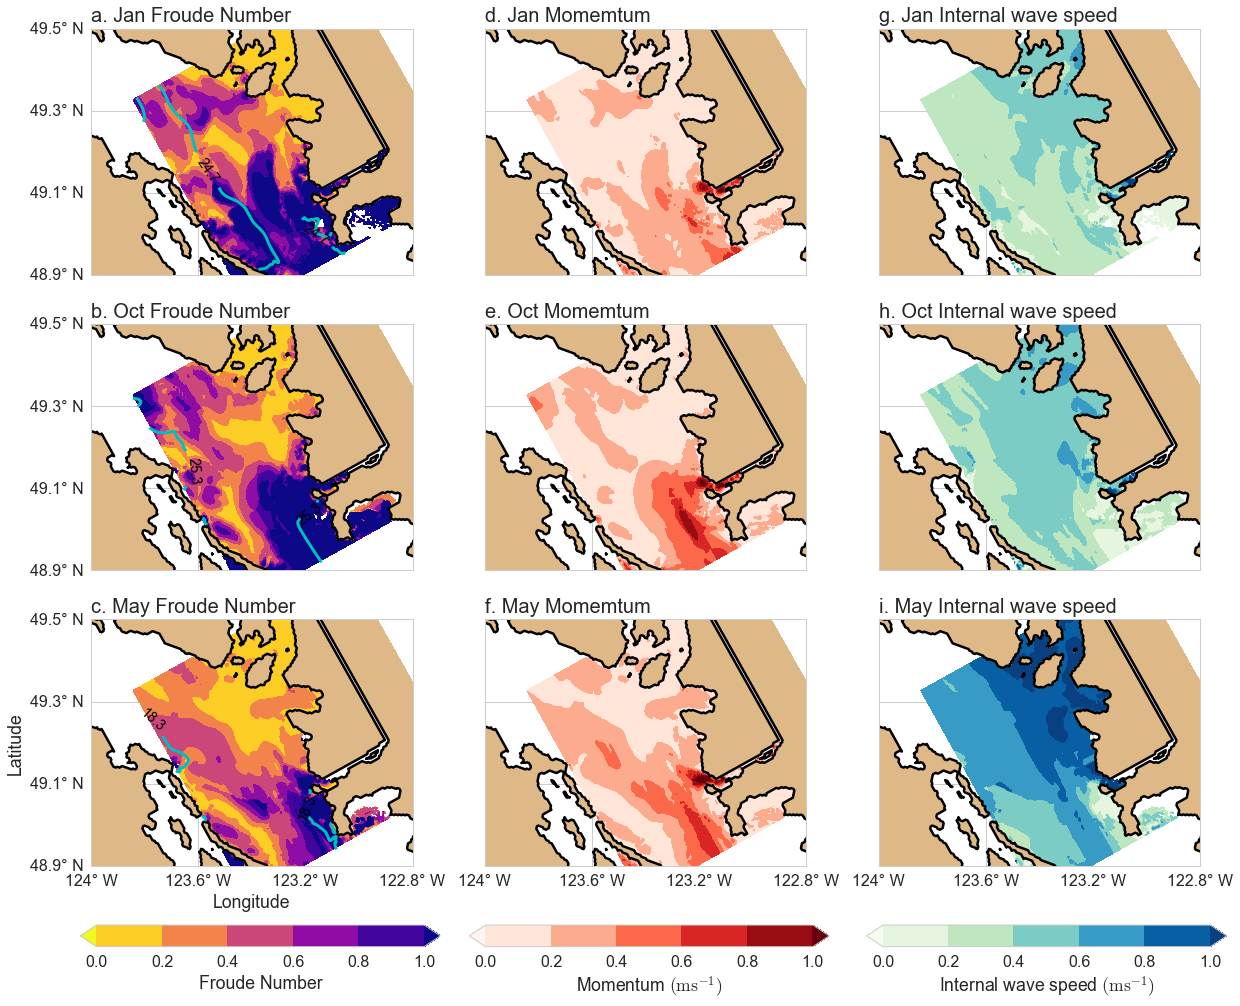

In [93]:
## peak ebb
degree_sign= u'\N{DEGREE SIGN}'+' W'
degree_signLat= u'\N{DEGREE SIGN}'+' N'
fig, axs = plt.subplots(3,3,figsize = (20,15))
for gridT,gridU,gridV, i, t,S_thre in zip([janall_T,octall_T,mayall_T],[janall_U,octall_U,mayall_U],\
                            [janall_V,octall_V,mayall_V], np.arange(3),[194,196,734], [24.7,25.3,18.3]):
    rho, u, v,dep, ssh = Extract_UVRHO(gridT,gridU,gridV,np_mask,t,ti)
    U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,Upper_depthsUV,Upper_depthsRho,\
    Bottom_depthsUV,Bottom_depthsRho,H = Calculate_Froude_Number(rho,u,v,dep,ssh,e3t,tmask, ti)
    Delta_Velocity, IWS, Fr = Final_Froude_Number(U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,\
                                                  Upper_depthsUV,Upper_depthsRho,Bottom_depthsUV,Bottom_depthsRho,H)
    
    dep = gridT.variables['deptht']
    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    if i ==0:
        letters = ['a. Jan Froude Number', 'd. Jan Momemtum ', 'g. Jan Internal wave speed']
    elif i ==1:
        letters = ['b. Oct Froude Number', 'e. Oct Momemtum', 'h. Oct Internal wave speed']
    elif i ==2:
        letters = ['c. May Froude Number', 'f. May Momemtum', 'i. May Internal wave speed']
    for ax, snapshot, string,level,cb,letter in zip(axs[i,:],[Fr,Delta_Velocity,IWS],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Internal wave speed $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu'], letters):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        ax.text(0,1.03,letter, transform = ax.transAxes,fontsize = 20)
        if ax == axs[2,0]:
            cbar_ax = fig.add_axes([0.12, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,1]:
            cbar_ax = fig.add_axes([0.39, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,2]:
            cbar_ax = fig.add_axes([0.666, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([str(124) +degree_sign, str(123.6)+degree_sign,str(123.2)+degree_sign,str(122.8)+degree_sign])
        ax.set_yticks([48.9,49.1,49.3,49.5])
        ax.set_yticklabels([str(48.9) +degree_signLat, str(49.1)+degree_signLat,str(49.3)+degree_signLat,str(49.5)+degree_signLat])
        viz_tools.set_aspect(ax,coords='map',lats = lat)
        if letter == 'c. May Froude Number':
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
        if letter == 'a. Jan Froude Number' or letter == 'b. Oct Froude Number':
            plt.setp( ax.get_xticklabels(), visible=False)
        if letter =='d. Jan Momemtum ' or letter =='g. Jan Internal wave speed' \
        or letter == 'e. Oct Momemtum' or letter =='h. Oct Internal wave speed':
            plt.setp( ax.get_xticklabels(), visible=False)
            plt.setp( ax.get_yticklabels(), visible=False)
        if letter =='f. May Momemtum' or letter =='i. May Internal wave speed':
            plt.setp( ax.get_yticklabels(), visible=False)
            
    ax = axs[i,0]
    SS,W = determine_plume_method2_onlysalinity(gridT,t,t+1,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)


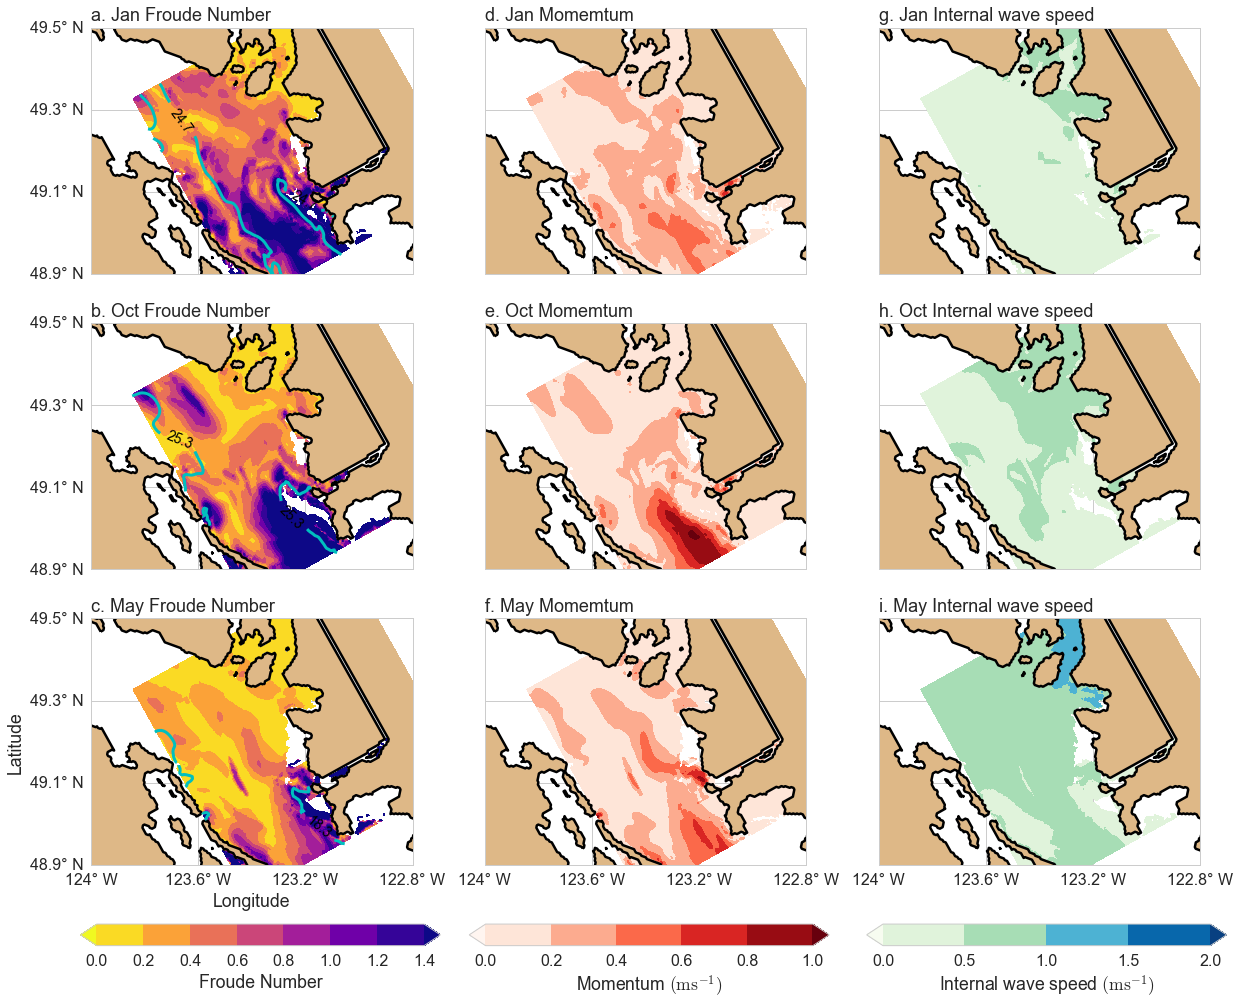

In [18]:
## peak flood
fig, axs = plt.subplots(3,3,figsize = (20,15))
for gridT,gridU,gridV, i, t,S_thre in zip([janall_T,octall_T,mayall_T],[janall_U,octall_U,mayall_U],\
                            [janall_V,octall_V,mayall_V], np.arange(3),[204,204,740],[24.7,25.3,18.3]):
    rho, u, v,dep, ssh = Extract_UVRHO(gridT,gridU,gridV,np_mask,t,ti)
    U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,Upper_depthsUV,Upper_depthsRho,\
    Bottom_depthsUV,Bottom_depthsRho,H = Calculate_Froude_Number(rho,u,v,dep,ssh,e3t,tmask, ti)
    Delta_Velocity, IWS, Fr = Final_Froude_Number(U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,\
                                                  Upper_depthsUV,Upper_depthsRho,Bottom_depthsUV,Bottom_depthsRho,H)
    dep = gridT.variables['deptht']
    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    if i ==0:
        letters = ['a. Jan Froude Number', 'd. Jan Momemtum ', 'g. Jan Internal wave speed']
    elif i ==1:
        letters = ['b. Oct Froude Number', 'e. Oct Momemtum', 'h. Oct Internal wave speed']
    elif i ==2:
        letters = ['c. May Froude Number', 'f. May Momemtum', 'i. May Internal wave speed']
    for ax, snapshot, string,level,cb,letter in zip(axs[i,:],[Fr,Delta_Velocity,IWS],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Internal wave speed $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu'], letters):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        ax.text(0,1.03,letter, transform = ax.transAxes,fontsize = 18)
        if ax == axs[2,0]:
            cbar_ax = fig.add_axes([0.12, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,1]:
            cbar_ax = fig.add_axes([0.39, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,2]:
            cbar_ax = fig.add_axes([0.666, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([str(124) +degree_sign, str(123.6)+degree_sign,str(123.2)+degree_sign,str(122.8)+degree_sign])
        ax.set_yticks([48.9,49.1,49.3,49.5])
        ax.set_yticklabels([str(48.9) +degree_signLat, str(49.1)+degree_signLat,str(49.3)+degree_signLat,str(49.5)+degree_signLat])
        viz_tools.set_aspect(ax,coords='map',lats = lat)
        if letter == 'c. May Froude Number':
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
        if letter == 'a. Jan Froude Number' or letter == 'b. Oct Froude Number':
            plt.setp( ax.get_xticklabels(), visible=False)
        if letter =='d. Jan Momemtum ' or letter =='g. Jan Internal wave speed' \
        or letter == 'e. Oct Momemtum' or letter =='h. Oct Internal wave speed':
            plt.setp( ax.get_xticklabels(), visible=False)
            plt.setp( ax.get_yticklabels(), visible=False)
        if letter =='f. May Momemtum' or letter =='i. May Internal wave speed':
            plt.setp( ax.get_yticklabels(), visible=False)
    ax = axs[i,0]
    SS,W = determine_plume_method2_onlysalinity(gridT,t,t+1,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)

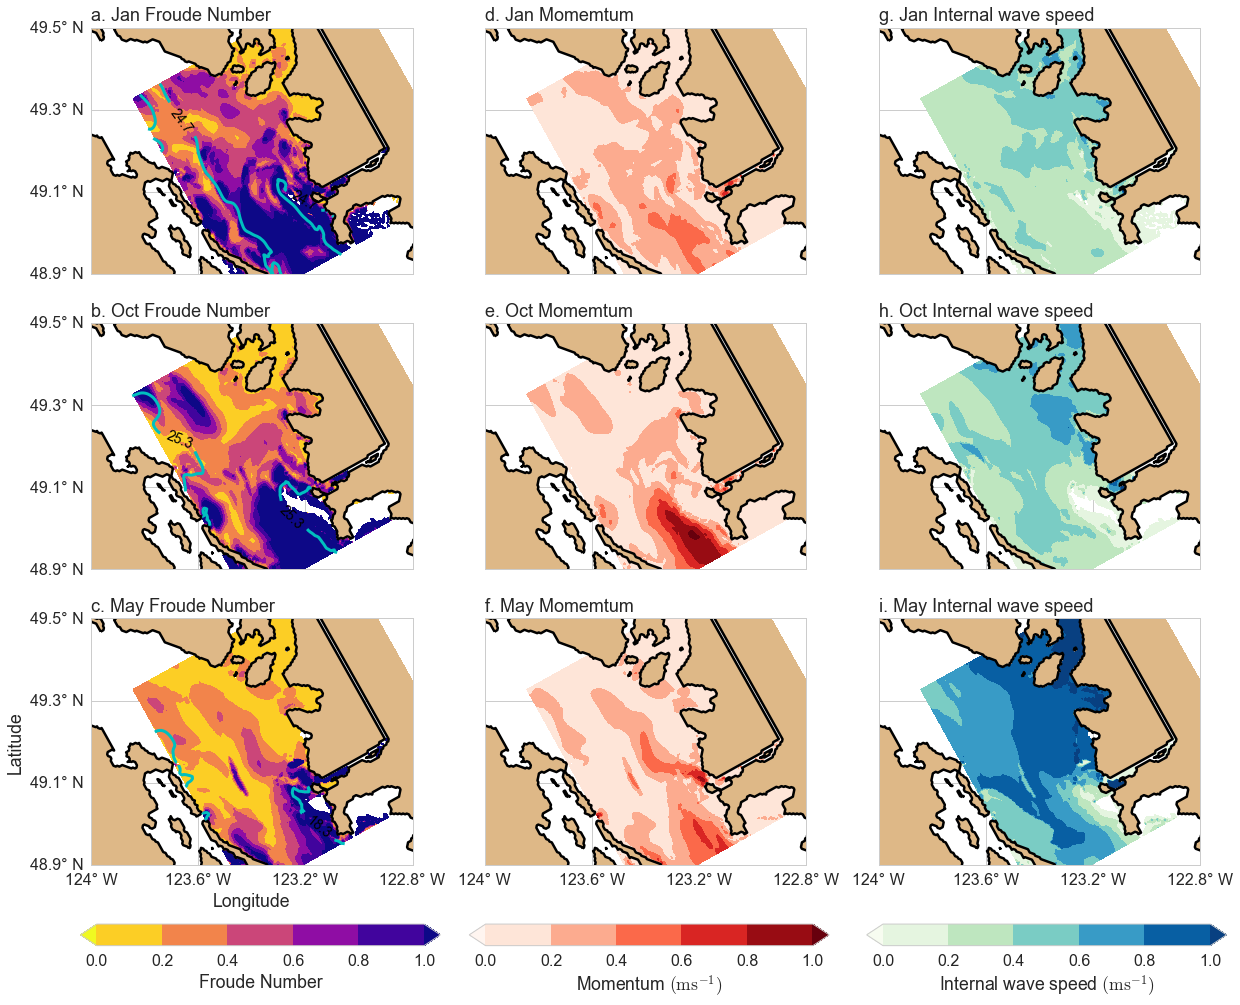

In [91]:
## peak flood again with nan handled
fig, axs = plt.subplots(3,3,figsize = (20,15))
for gridT,gridU,gridV, i, t,S_thre in zip([janall_T,octall_T,mayall_T],[janall_U,octall_U,mayall_U],\
                            [janall_V,octall_V,mayall_V], np.arange(3),[204,204,740],[24.7,25.3,18.3]):
    rho, u, v,dep, ssh = Extract_UVRHO(gridT,gridU,gridV,np_mask,t,ti)
    U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,Upper_depthsUV,Upper_depthsRho,\
    Bottom_depthsUV,Bottom_depthsRho,H = Calculate_Froude_Number(rho,u,v,dep,ssh,e3t,tmask, ti)
    Delta_Velocity, IWS, Fr = Final_Froude_Number(U_upper,V_upper,U_bottom,V_bottom,Rho_upper,Rho_bottom,\
                                                  Upper_depthsUV,Upper_depthsRho,Bottom_depthsUV,Bottom_depthsRho,H)
    dep = gridT.variables['deptht']
    lon = gridT.variables['nav_lon']
    lat = gridT.variables['nav_lat']
    if i ==0:
        letters = ['a. Jan Froude Number', 'd. Jan Momemtum ', 'g. Jan Internal wave speed']
    elif i ==1:
        letters = ['b. Oct Froude Number', 'e. Oct Momemtum', 'h. Oct Internal wave speed']
    elif i ==2:
        letters = ['c. May Froude Number', 'f. May Momemtum', 'i. May Internal wave speed']
    for ax, snapshot, string,level,cb,letter in zip(axs[i,:],[Fr,Delta_Velocity,IWS],\
                                    ['Froude Number','Momentum $\mathrm{(m s^{-1})}$','Internal wave speed $\mathrm{(m s^{-1})}$'],[levels_Fr,levels_M,levels_B],\
                                    ['plasma_r','Reds','GnBu'], letters):
        CS = ax.contourf(lon[1:,1:],lat[1:,1:],snapshot,level,cmap = cb,extend='both')
        ax.text(0,1.03,letter, transform = ax.transAxes,fontsize = 18)
        if ax == axs[2,0]:
            cbar_ax = fig.add_axes([0.12, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,1]:
            cbar_ax = fig.add_axes([0.39, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        if ax == axs[2,2]:
            cbar_ax = fig.add_axes([0.666, 0.05, 0.25, 0.02])
            cbar = fig.colorbar(CS,cax = cbar_ax,orientation = 'horizontal')
            cbar.set_label(string)
        viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        ax.set_xlim([lonmin,lonmax])
        ax.set_ylim([latmin,latmax])
        ax.set_xticks([-124,-123.6,-123.2,-122.8])
        ax.set_xticklabels([str(124) +degree_sign, str(123.6)+degree_sign,str(123.2)+degree_sign,str(122.8)+degree_sign])
        ax.set_yticks([48.9,49.1,49.3,49.5])
        ax.set_yticklabels([str(48.9) +degree_signLat, str(49.1)+degree_signLat,str(49.3)+degree_signLat,str(49.5)+degree_signLat])
        viz_tools.set_aspect(ax,coords='map',lats = lat)
        if letter == 'c. May Froude Number':
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
        if letter == 'a. Jan Froude Number' or letter == 'b. Oct Froude Number':
            plt.setp( ax.get_xticklabels(), visible=False)
        if letter =='d. Jan Momemtum ' or letter =='g. Jan Internal wave speed' \
        or letter == 'e. Oct Momemtum' or letter =='h. Oct Internal wave speed':
            plt.setp( ax.get_xticklabels(), visible=False)
            plt.setp( ax.get_yticklabels(), visible=False)
        if letter =='f. May Momemtum' or letter =='i. May Internal wave speed':
            plt.setp( ax.get_yticklabels(), visible=False)
    ax = axs[i,0]
    SS,W = determine_plume_method2_onlysalinity(gridT,t,t+1,0) ## use surface salinity to define plume edge
    CS3 = ax.contour(lon[:],lat[:],W, levels = [S_thre], colors='c',linewidths=(3,))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)

In [81]:
geo_tools.find_closest_model_point(-123.24,49.2,X,Y,land_mask=bathy.mask)

(442, 314)

In [82]:
Delta_Velocity[62,74]

0.11303007100165496

In [89]:
np.nansum(Rho_upper[:,63,75],axis = 0)/np.nansum(Upper_depthsRho[:,63,75],axis = 0)

1000.417764201244

In [87]:
Bottom_depthsRho[:,63,75]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [53]:
tmask[:,63,75]

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

In [54]:
rho[:,63,75]

masked_array(data = [998.4169311523438 998.4095458984375 1000.36572265625 1004.478759765625 --
 -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
 -- -- -- -- -- -- -- -- -- --],
             mask = [False False False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True],
       fill_value = 1e+20)

In [55]:
U_upper[:,62,74]

array([ 0.00100747, -0.00134675,  0.00706932, -0.00700028,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [62]:
np.nansum(U_bottom[:,62,74],axis =0)/np.nansum(Bottom_depthsUV[:,62,74], axis = 0)

nan

In [63]:
Bottom_depthsRho[:,62,74]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [92]:
v[ti][:,62,74]

array([ 0.11249129,  0.11572941,  0.17185184,  0.05204851,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ], dtype=float32)

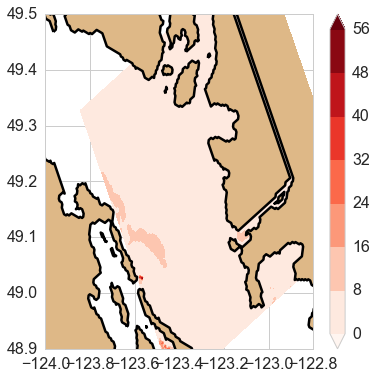

In [69]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
snapshot = Delta_Velocity
CS = ax.contourf(lon[1:,1:],lat[1:,1:],np.nansum(Upper_depthsUV,axis = 0),cmap = 'Reds',extend='both')
viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
viz_tools.plot_coastline(ax, grid6, coords = 'map')
ax.set_xlim([lonmin,lonmax])
ax.set_ylim([latmin,latmax])
cbar =fig.colorbar(CS)